## Packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

## Creating The Dataset And Splitting It Into Training And Validation Sets

In [2]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = "dataset/"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 327 files belonging to 2 classes.
Using 262 files for training.
Found 327 files belonging to 2 classes.
Using 65 files for validation.


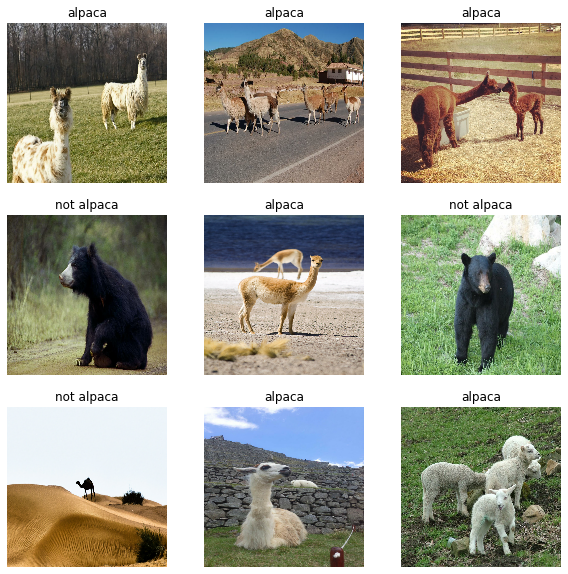

In [3]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Preprocessing And Augmenting Training Data

In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

### Data Augmenter

In [5]:
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip("horizontal"))
    data_augmentation.add(RandomRotation(0.2))
    
    return data_augmentation

From one animal, to 9 variations of that animal:

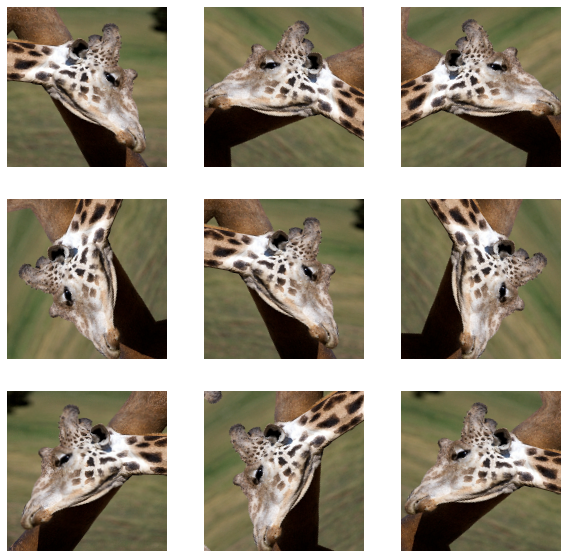

In [6]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

Next, we'll apply our first tool from the MobileNet application in TensorFlow, to normalize our input. Since we're using a pre-trained model that was trained on the normalization values [-1,1], it's best practice to reuse that standard with tf.keras.applications.mobilenet_v2.preprocess_input.  


<b>What we should remember:</b>  

* When calling image_data_set_from_directory(), specify the train/val subsets and match the seeds to prevent overlap
* Use prefetch() to prevent memory bottlenecks when reading from disk
* Give your model more to learn from with simple data augmentations like rotation and flipping.
* When using a pretrained model, it's best to reuse the weights it was trained on.

In [7]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

## Using MobileNetV2 For Transfer Learning

MobileNetV2 was trained on ImageNet and is optimized to run on mobile and other low-power applications. It's 155 layers deep and very efficient for object detection and image segmentation tasks, as well as classification tasks like this one. The architecture has three defining characteristics:  

* Depthwise separable convolutions
* Thin input and output bottlenecks between layers
* Shortcut connections between bottleneck layers

### Inside A MobileNetV2 Convolutional Building Block

MobileNetV2 uses depthwise separable convolutions as efficient building blocks. Traditional convolutions are often very resource-intensive, and depthwise separable convolutions are able to reduce the number of trainable parameters and operations and also speed up convolutions in two steps:  

1-) The first step calculates an intermediate result by convolving on each of the channels independently. This is the depthwise convolution.

2-) In the second step, another convolution merges the outputs of the previous step into one. This gets a single result from a single feature at a time, and then is applied to all the filters in the output layer. This is the pointwise convolution, or: Shape of the depthwise convolution X Number of filters.

Each block consists of an inverted residual structure with a bottleneck at each end. These bottlenecks encode the intermediate inputs and outputs in a low dimensional space, and prevent non-linearities from destroying important information.  

The shortcut connections, which are similar to the ones in traditional residual networks, serve the same purpose of speeding up training and improving predictions. These connections skip over the intermediate convolutions and connect the bottleneck layers.

Similarly to how you reused the pretrained normalization values MobileNetV2 was trained on, you'll also load the pretrained weights from ImageNet by specifying weights='imagenet'.

In [8]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

In [9]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

Note the last 2 layers here. They are so called the top layers, and they are responsible of the classification in the model.

In [10]:
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)
print(base_model.layers[nb_layers - 1].name)

global_average_pooling2d
predictions


<b>What we should remember:</b>  

* MobileNetV2's unique features are:
    - Depthwise separable convolutions that provide lightweight feature filtering and creation
    - Input and output bottlenecks that preserve important information on either end of the block
* Depthwise separable convolutions deal with both spatial and depth (number of channels) dimensions

Next, choose the first batch from the tensorflow dataset to use the images, and run it through the MobileNetV2 base model to test out the predictions on some of your images.

In [11]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 1000)


In [12]:
#Shows the different label probabilities in one tensor 
label_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 0])>

Now decode the predictions made by the model. Earlier, when you printed the shape of the batch, it would have returned (32, 1000). The number 32 refers to the batch size and 1000 refers to the 1000 classes the model was pretrained on. The predictions returned by the base model below follow this format:

First the class number, then a human-readable label, and last the probability of the image belonging to that class. You'll notice that there are two of these returned for each image in the batch - these the top two probabilities returned for that image.

In [13]:
base_model.trainable = False
image_var = tf.Variable(image_batch)
pred = base_model(image_var)

tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(), top=2)

[[('n04589890', 'window_screen', 0.4258225),
  ('n02708093', 'analog_clock', 0.09275609)],
 [('n04589890', 'window_screen', 0.23985955),
  ('n03887697', 'paper_towel', 0.1480277)],
 [('n04589890', 'window_screen', 0.7449466),
  ('n03598930', 'jigsaw_puzzle', 0.021948999)],
 [('n04589890', 'window_screen', 0.3354606),
  ('n03530642', 'honeycomb', 0.07628959)],
 [('n04589890', 'window_screen', 0.27327397),
  ('n03733281', 'maze', 0.08846995)],
 [('n04589890', 'window_screen', 0.6745268),
  ('n03530642', 'honeycomb', 0.07659892)],
 [('n04589890', 'window_screen', 0.791286),
  ('n04209239', 'shower_curtain', 0.09241604)],
 [('n04589890', 'window_screen', 0.1646305),
  ('n03598930', 'jigsaw_puzzle', 0.087492496)],
 [('n03598930', 'jigsaw_puzzle', 0.37021375),
  ('n04589890', 'window_screen', 0.09957081)],
 [('n04589890', 'window_screen', 0.61616826),
  ('n03887697', 'paper_towel', 0.05487683)],
 [('n03530642', 'honeycomb', 0.25448847),
  ('n04589890', 'window_screen', 0.24874586)],
 [('n045

There's a whole lot of labels here, some of them hilariously wrong, but none of them say "alpaca."

This is because MobileNet pretrained over ImageNet doesn't have the correct labels for alpacas, so when we use the full model, all we get is a bunch of incorrectly classified images.

Fortunately, we can delete the top layer, which contains all the classification labels, and create a new classification layer.

## Layer Freezing With The Functional API

In the next sections, we'll see how we can use a pretrained model to modify the classifier task so that it's able to recognize alpacas. we can achieve this in three steps:

* Delete the top layer (the classification layer)  
    - Set include_top in base_model as False  
* Add a new classifier layer  
    - Train only one layer by freezing the rest of the network  
    - As mentioned before, a single neuron is enough to solve a binary classification problem.  
* Freeze the base model and train the newly-created classifier layer  
    - Set base model.trainable=False to avoid changing the weights and train only the new layer  
    - Set training in base_model to False to avoid keeping track of statistics in the batch norm layer  

### Alpaca Model

In [14]:
def alpaca_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    ''' Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''
    
    
    input_shape = image_shape + (3,)
    
    
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False, # <== Important!!!!
                                                   weights='imagenet') # From imageNet
    
    # Freeze the base model by making it non trainable
    base_model.trainable = False
    
    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) 
    
    # apply data augmentation to the inputs
    x = data_augmentation(inputs)
    
    # data preprocessing using the same weights the model was trained on
    # Already Done -> preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
    x = preprocess_input(x) 
    
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 
    
    # Add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tfl.GlobalAveragePooling2D()(x) 
    #include dropout with probability of 0.2 to avoid overfitting
    x = tfl.Dropout(0.2)(x)
        
    # create a prediction layer with one neuron (as a classifier only needs one)
    prediction_layer = tfl.Dense(1)
        
    outputs = prediction_layer(x) 
    model = tf.keras.Model(inputs, outputs)
    
    return model

Create our new model using the data_augmentation function defined earlier.

In [15]:
model2 = alpaca_model(IMG_SIZE, data_augmentation)

In [16]:
base_learning_rate = 0.01
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
initial_epochs = 5
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5
9/9 [==============================] - 7s 283ms/step - loss: 0.5713 - accuracy: 0.6794 - val_loss: 0.1823 - val_accuracy: 0.9231
Epoch 2/5
9/9 [==============================] - 2s 94ms/step - loss: 0.3505 - accuracy: 0.8588 - val_loss: 0.1128 - val_accuracy: 0.9538
Epoch 3/5
9/9 [==============================] - 2s 93ms/step - loss: 0.2448 - accuracy: 0.9084 - val_loss: 0.2111 - val_accuracy: 0.8615
Epoch 4/5
9/9 [==============================] - 1s 86ms/step - loss: 0.3016 - accuracy: 0.8702 - val_loss: 0.0860 - val_accuracy: 0.9846
Epoch 5/5
9/9 [==============================] - 1s 90ms/step - loss: 0.2793 - accuracy: 0.9046 - val_loss: 0.0825 - val_accuracy: 0.9538


## Plotting The Training And Validation Accuracy 

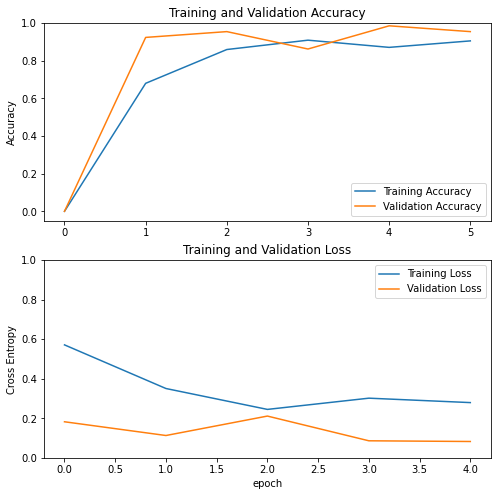

In [18]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [19]:
class_names

['alpaca', 'not alpaca']

The results are ok, but could be better. Next, try some fine-tuning.

## Fine Tuning The Model

We could try fine-tuning the model by re-running the optimizer in the last layers to improve accuracy. When we use a smaller learning rate, we take smaller steps to adapt it a little more closely to the new data. In transfer learning, the way we achieve this is by unfreezing the layers at the end of the network, and then re-training your model on the final layers with a very low learning rate. Adapting our learning rate to go over these layers in smaller steps can yield more fine details - and higher accuracy.

The intuition for what's happening: when the network is in its earlier stages, it trains on low-level features, like edges. In the later layers, more complex, high-level features like wispy hair or pointy ears begin to emerge. For transfer learning, the low-level features can be kept the same, as they have common features for most images. When we add new data, we generally want the high-level features to adapt to it, which is rather like letting the network learn to detect features more related to our data, such as soft fur or big teeth.

To achieve this, just unfreeze the final layers and re-run the optimizer with a smaller learning rate, while keeping all the other layers frozen.

Where the final layers actually begin is a bit arbitrary, so feel free to play around with this number a bit. The important takeaway is that the later layers are the part of our network that contain the fine details (pointy ears, hairy tails) that are more specific to your problem.

First, unfreeze the base model by setting base_model.trainable=True, set a layer to fine-tune from, then re-freeze all the layers before it. Run it again for another few epochs, and see if our accuracy improved!

In [20]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 126

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = None
    
# Define a BinaryCrossentropy loss function. Use from_logits=True
loss_function= tf.keras.losses.BinaryCrossentropy(from_logits=True)
# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate*0.1)# 0.001
# Use accuracy as evaluation metric
metrics=['accuracy']

model2.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

Number of layers in the base model:  156


In [21]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 5/10
9/9 [==============================] - 7s 209ms/step - loss: 0.2303 - accuracy: 0.9046 - val_loss: 0.0714 - val_accuracy: 0.9692
Epoch 6/10
9/9 [==============================] - 1s 75ms/step - loss: 0.1544 - accuracy: 0.9313 - val_loss: 0.0804 - val_accuracy: 0.9231
Epoch 7/10
9/9 [==============================] - 2s 96ms/step - loss: 0.1750 - accuracy: 0.9313 - val_loss: 0.0829 - val_accuracy: 0.9385
Epoch 8/10
9/9 [==============================] - 2s 99ms/step - loss: 0.1437 - accuracy: 0.9351 - val_loss: 0.0799 - val_accuracy: 0.9538
Epoch 9/10
9/9 [==============================] - 2s 92ms/step - loss: 0.1326 - accuracy: 0.9313 - val_loss: 0.0840 - val_accuracy: 0.9231
Epoch 10/10
9/9 [==============================] - 2s 87ms/step - loss: 0.1246 - accuracy: 0.9504 - val_loss: 0.0764 - val_accuracy: 0.9692


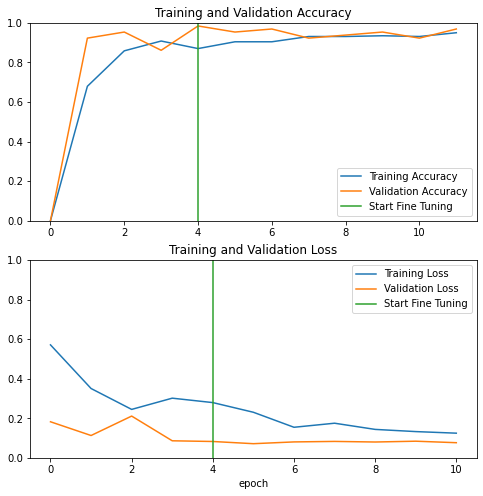

In [22]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

<b>What you should remember:</b>  

* To adapt the classifier to new data: Delete the top layer, add a new classification layer, and train only on that layer
* When freezing layers, avoid keeping track of statistics (like in the batch normalization layer)
* Fine-tune the final layers of your model to capture high-level details near the end of the network and potentially improve accuracy